In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt

C:\Users\Chaitanya\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [236]:
start_date="2013-01-01"
end_date="2020-01-01"
goog_data=data.DataReader('GAIL.NS', 'yahoo', start_date, end_date)

In [237]:
goog_data1=goog_data.tail(620)
lows=goog_data1["Low"]
highs=goog_data1["High"]

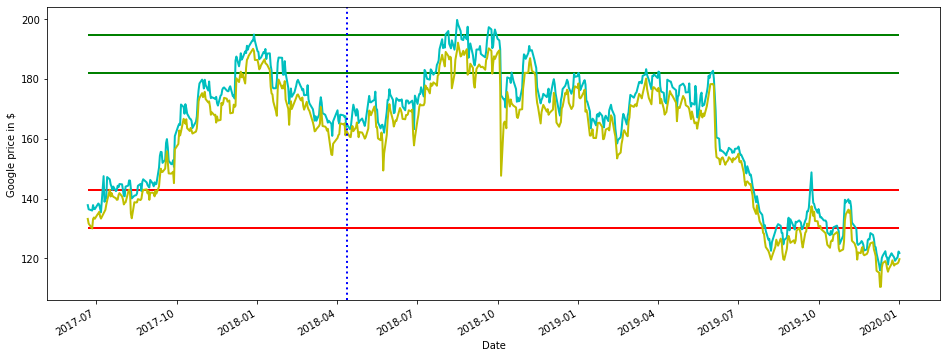

In [238]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(111, ylabel='Google price in $')
highs.plot(ax=ax1,color="c",lw=2)
lows.plot(ax=ax1,color="y",lw=2)
plt.hlines(highs.head(200).max(),lows.index.values[0],lows.index.values[-1],lw=2,color="g")
plt.hlines(highs.head(200).max()-0.2*(highs.head(200).max()-lows.head(200).min()),lows.index.values[0],lows.index.values[-1],lw=2,color="g")
plt.hlines(lows.head(200).min(),lows.index.values[0],lows.index.values[-1],lw=2,color="r")
plt.hlines(lows.head(200).min()+0.2*(highs.head(200).max()-lows.head(200).min()),lows.index.values[0],lows.index.values[-1],lw=2,color="r")
plt.axvline(lw=2,color="b",x=lows.index.values[200],ls=":")

In [239]:
goog_data_signal=pd.DataFrame(index=goog_data.index)
goog_data_signal["price"]=goog_data["Adj Close"]

In [240]:
def trading_support_resistance(data,bin_width=20):
    data['sup_tolerance'] = pd.Series(np.zeros(len(data)))
    data['res_tolerance'] = pd.Series(np.zeros(len(data)))
    data['sup_count'] = pd.Series(np.zeros(len(data)))
    data['res_count'] = pd.Series(np.zeros(len(data)))
    data['sup'] = pd.Series(np.zeros(len(data)))
    data['res'] = pd.Series(np.zeros(len(data)))
    data['positions'] = pd.Series(np.zeros(len(data)))
    data['signal'] = pd.Series(np.zeros(len(data)))
    in_support=0
    in_resistance=0
    for x in range((bin_width - 1) + bin_width, len(data)):
        data_section = data[x - bin_width:x + 1]#Selects a 20 day window from which res and sup will be calculated
        support_level=min(data_section['price'])#Support level for window is calculated
        resistance_level=max(data_section['price'])#Resistance Level for window is calculated
        range_level=resistance_level-support_level#Range for window
        data['res'][x]=resistance_level#Adding resistance level to dataframe
        data['sup'][x]=support_level#Adding support level to dataframe
        data['sup_tolerance'][x]=support_level + 0.2 * range_level#adding tolerance to support level
        data['res_tolerance'][x]=resistance_level - 0.2 * range_level#adding tolerance to resistance level
        
        #If the price is between resistance tolerance and resistance then it means it has touched the resistance ones
        
        if data['price'][x]>=data['res_tolerance'][x] and\
                             data['price'][x] <= data['res'][x]:
            in_resistance+=1#Adding a count of 1
            data['res_count'][x]=in_resistance#Cumulating the number of times resistance level is touched upon
        
        #If the price is between support tolerance and support then it menas it has touched the support ones
            
        elif data['price'][x] <= data['sup_tolerance'][x] and \
                                 data['price'][x] >= data['sup'][x]:
            in_support += 1#Adding a Count of 1
            data['sup_count'][x] = in_support#Cumulating the no. of times support level is touched

        #If the price do not lie either between sup or res tolerance then reassign support and resistance count to 0

        else:
            in_support=0
            in_resistance=0
#         If the res is touched more than twice then enter a short position
        if in_resistance>2:
            data['signal'][x]=0
#         If the sup is touched more than twice then enter a long position
        elif in_support>2:
             data['signal'][x]=1
        else:
             data['signal'][x] = data['signal'][x-1]
    data['positions']=data['signal'].diff()


In [269]:
trading_support_resistance(goog_data_signal,bin_width=100)

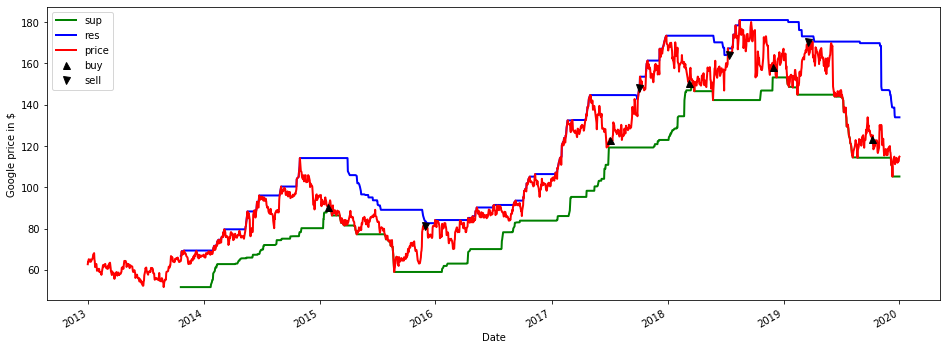

In [270]:
fig=plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(111, ylabel='Google price in $')
goog_data_signal['sup'].plot(ax=ax1, color='g', lw=2.)
goog_data_signal['res'].plot(ax=ax1, color='b', lw=2.)
goog_data_signal['price'].plot(ax=ax1, color='r', lw=2.)
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == 1.0].index,
 goog_data_signal.price[goog_data_signal.positions == 1.0],
 '^', markersize=7, color='k',label='buy')
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == -1.0].index,
 goog_data_signal.price[goog_data_signal.positions == -1.0],
 'v', markersize=7, color='k',label='sell')
plt.legend()


# Backtesting

In [271]:
# Declare the initial capital

initial_capital=float(300.0)
# Create a dataframe for positions and portfolio

positions=pd.DataFrame(index=goog_data_signal.index).fillna(0.0)
portfolio=pd.DataFrame(index=goog_data_signal.index).fillna(0.0)

# Store the GOOG positions in the portfolio

positions["GOOG"]=goog_data_signal["signal"]
portfolio["positions"]=(positions.multiply(goog_data_signal["price"],axis=0))#It accounts the positions at the end of day.

# Calculate the non-invested money(cash)

portfolio["cash"]=initial_capital-(positions.diff().multiply(goog_data_signal.price,axis=0)).cumsum()#It contains the cashout at the end of day when the stock was sold
portfolio["total"]=portfolio["cash"]+portfolio["positions"]

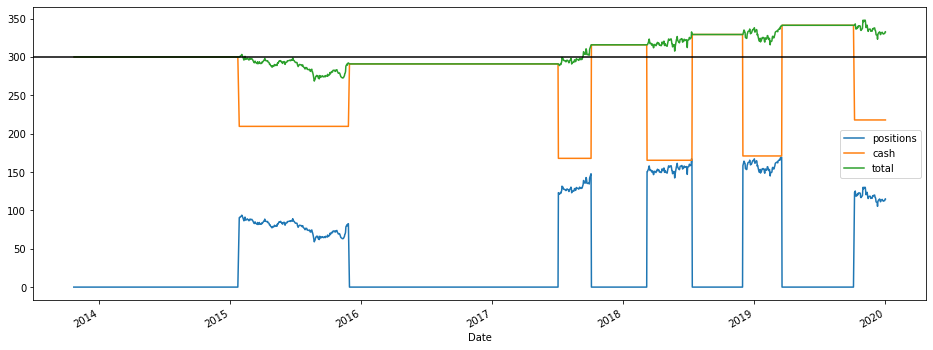

In [272]:
portfolio.plot(figsize=(16,6))
plt.axhline(y=initial_capital,color="k")

In [273]:
# Calculate the no. of trades
np.sum(np.abs(goog_data_signal.positions))/2

4.5

In [274]:
# Return at the end of the period
np.prod((1+portfolio["total"].pct_change().dropna()))

1.1090382130940721

In [275]:
# Return at the end of the period
portfolio["total"].pct_change().dropna()

Date
2013-10-25    0.000000
2013-10-28    0.000000
2013-10-29    0.000000
2013-10-30    0.000000
2013-10-31    0.000000
                ...   
2019-12-26   -0.004720
2019-12-27    0.001293
2019-12-30    0.001005
2019-12-31    0.006165
2020-01-01    0.000427
Name: total, Length: 1518, dtype: float64

In [276]:
#CAGR
((np.prod((1+portfolio["total"].pct_change().dropna())))**(252/1518)-1)*100

1.732912032904843